# Data inference - CBA 2020

## Import packages

In [57]:
!pip install wordcloud

In [58]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.6 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [59]:
import numpy as np
import pandas as pd
import json
import gdown

# For advanced NLP Processing
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import en_core_web_lg
import re
import matplotlib.pyplot as plt
from unicodedata import normalize, combining
from tqdm import tqdm
from wordcloud import WordCloud, ImageColorGenerator

import tensorflow as tf
from tensorflow import keras

In [60]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## CBA 2020

### Load data

In [61]:
# Load data
url = "https://drive.google.com/uc?id=1W8QxgW1lrBp_k9R7zomu4itctaXZoAUa"
gdown.download(url, quiet=True)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1W8QxgW1lrBp_k9R7zomu4itctaXZoAUa 



In [62]:
with open("titles_en.json", "r") as file:
  cba = json.load(file)

### Preprocess data

In [63]:
def get_stopwords():
    nltk_stopwords = nltk.corpus.stopwords.words("english")
    spacy_en = en_core_web_lg.load()
    spacy_stopwords = spacy_en.Defaults.stop_words
    
    stopwords = list(set(spacy_stopwords).union(set(nltk_stopwords)))
 
    return stopwords

In [64]:
def advanced_preprocess(X, truncation="lemma"):
    # Convert text to lowercase
    Z = [text.lower() for text in X] 

    # Remove special characters
    special_char_reg_ex="!@#$%^&*()[]{};:,./<>?\|`~-=_+123456789"
    Z = [text.translate({ord(char): " " for char in special_char_reg_ex}) for text in Z]

    # Remove numbers
    Z = [re.sub(r"^\d+\s|\s\d+\s|\s\d+$|\d+\)", ' ', text) for text in Z]

    # Remove double spaces
    Z = [re.sub(r"\s+[a-zA-Z]\s+", ' ', text) for text in Z]

    # Remove accents
    Z = ["".join([char for char in normalize("NFKD", text) if not combining(char)]) for text in Z]

    # Tokenize text
    Z = [word_tokenize(text) for text in Z]

    # Remove stopwords
    stopwords = get_stopwords()
    Z = [list((word for word in tokens if ((word not in stopwords) and (len(word) > 1)))) for tokens in Z]
    
    # Lemmatizing
    if truncation == "lemma":
        # Concatenate tokens
        Z = [" ".join(tokens) for tokens in Z]

        # Lemmatize sentences
        nlp = en_core_web_lg.load()
        lemmatize = lambda sentence: " ".join([token.lemma_ for token in nlp(sentence)])
        Z = [lemmatize(text) for text in tqdm(Z)]
    
    # Stemming
    if truncation == "stem":
        stemmer = SnowballStemmer("english")
        Z = [" ".join([stemmer.stem(token) for token in tokens]) for tokens in Z]
        
    if truncation is None:
        Z = [" ".join(tokens) for tokens in Z]

    # Convert back to np.array
    Z = np.array(Z)
    
    # Discard empty sentences 
    non_empty_sentences = Z != "" 
    Z = Z[non_empty_sentences]
    
    return Z

In [65]:
X = advanced_preprocess(np.array(cba))

100%|██████████| 777/777 [00:08<00:00, 94.04it/s]


In [66]:
cba_set = tf.constant(X)

## Load Model

In [67]:
def get_weighted_loss(weights):
    def weighted_loss(y_train, y_pred):
        return keras.backend.mean((weights[:, 0] ** (1-y_train)) * (weights[:, 1] ** (y_train)) *\
                      keras.backend.binary_crossentropy(y_train, y_pred), axis=-1)
    return weighted_loss

In [68]:
# Download and load model
url = "https://drive.google.com/drive/folders/1DC0eVpkmHGCQJq2EOwyjINjjrlFxNKcz"
gdown.download_folder(url, quiet=True)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1hLA_m8_LkLVxcBQeT99toalaSlTeUK8o 



In [69]:
weights = np.zeros((16, 2))
weights[:, 0] = 1.
weights[:, 1] = 2.

model2 = tf.keras.models.load_model("model_2", 
                                   custom_objects={"weighted_loss": get_weighted_loss(weights)})

In [70]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (TextV  (None, 50)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 50, 50)            1000100   
                                                                 
 gru_5 (GRU)                 (None, 50, 50)            15300     
                                                                 
 gru_6 (GRU)                 (None, 50)                15300     
                                                                 
 dense_5 (Dense)             (None, 16)                816       
                                                                 
Total params: 1,031,516
Trainable params: 1,031,516
Non-trainable params: 0
____________________________________________

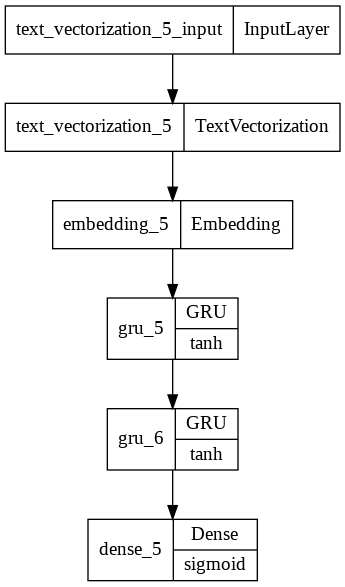

In [71]:
tf.keras.utils.plot_model(model2, "model2.png", show_layer_activations=True)

## Inference

In [72]:
y_pred = (model2.predict(cba_set) > 0.5) + 0

In [73]:
sdg_labels = ["SDG " + str(i+1) for i in range(16)]

In [74]:
predictions = pd.DataFrame(y_pred, columns=sdg_labels)
titles = pd.DataFrame(cba, columns=["Title"])

inference = pd.concat([titles, predictions], axis=1)

In [ ]:
inference.iloc[:, 1:].sum(axis=0)

SDG 1      18
SDG 2      18
SDG 3      57
SDG 4      66
SDG 5       4
SDG 6      13
SDG 7     500
SDG 8      22
SDG 9     437
SDG 10      9
SDG 11     47
SDG 12      4
SDG 13     12
SDG 14     14
SDG 15      6
SDG 16      8
dtype: int64

In [75]:
# Searching for minimum probability threshold such that the number of undefined papers is zero
y_proba = model2.predict(cba_set)

idx_undefined = inference[inference.iloc[:, 1:].sum(axis=1) == 0].index

minimum_threshold = 0.251  # obtained empirically 
sum(np.sum(y_proba[idx_undefined, :] > minimum_threshold, axis=1) != 0)

In [ ]:
np.unique(inference.iloc[:, 1:].sum(axis=1), return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 85, 199, 451,  35,   6,   1]))

In [ ]:
# count papers undefined
inference[inference.iloc[:, 1:].sum(axis=1) == 5]

,Title,SDG 1,SDG 2,SDG 3,SDG 4,SDG 5,SDG 6,SDG 7,SDG 8,SDG 9,SDG 10,SDG 11,SDG 12,SDG 13,SDG 14,SDG 15,SDG 16
255,Electric power generation from urban sanitary ...,0,0,0,0,0,0,1,1,1,0,1,0,1,0,0,0


In [ ]:
# plotting histogram
import seaborn as sns
import matplotlib

In [ ]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + float(space)
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center", fontdict={"fontsize": 10}) 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [ ]:
sns.set_theme(style="darkgrid")

counts = inference.iloc[:, 1:].sum(axis=0).sort_values(ascending=False)

# changing from SDG to ODS
counts.index = [sdg.replace('SDG', 'ODS') for sdg in counts.index]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.barplot(counts.index, counts.values, color='#3091D8',
            edgecolor="#3091D8")
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, 
                   rotation_mode="anchor", ha="left")

show_values_on_bars(ax, "v", 5)
ax.set(ylabel='Frequência')

plt.tight_layout()

# plt.grid()

# ax.set_facecolor("white")
# ax.spines["top"].set_color("white")
# ax.spines["right"].set_color("white")

# matplotlib.rc('axes', edgecolor='white')
plt.savefig("ods_histogram.png", dpi=400, facecolor="white")

cenários de avaliacao
- reforçar ocorrencias de sdgs
- analisar co ocorrencias de sdg 
- falar sobre o artigo com 5 SDGs
- nuvem de palavras (instâncias undefined)


Investigar threshold de probabilidade das instancias undefined

# WordCloud

In [ ]:
inference[inference.iloc[:, 1:].sum(axis=1) == 0]

In [ ]:
pd.Series(X).iloc[inference[inference.iloc[:, 1:].sum(axis=1) == 0].index].values

In [ ]:
len(pd.Series(X).iloc[inference[inference.iloc[:, 1:].sum(axis=1) == 0].index].values)

In [ ]:
# counts das co-ocorrencias

# SDG frequency on the pair.
filtered_inference = inference[inference.iloc[:, 1:].sum(axis=1) == 2]

sdg_count = filtered_inference.loc[:, filtered_inference.columns[1:]].sum(axis=0)
sdg_count = sdg_count.to_dict()
sdg_count = {sdg.replace(' ', '_'):value for sdg, value in sdg_count.items()}

# most frequent pair
pair_frequency = []
for _, row in filtered_inference.iterrows():
    '''There's no need to worry about the order, since always the smaller
    SDG, e.g. SDG_1 < SDG_7, thus, SDG_1 comes first.'''

    # preprocessing the pair data to append
    pair = row[row != 0].copy()
    pair = pair.index.to_list()
    pair = pair[1:]                 # remove the 'Title column'
    pair = '@'.join(pair)           # to make possible a groupby()

    pair_frequency.append(pair)

# creating the NEW dataframe and grouping the SDG strings
df_frequency = pd.DataFrame(pair_frequency, columns=['pair'])
df_frequency = df_frequency.groupby('pair').size()   # returns a series
df_frequency.name = 'frequency' # without this, when converted the series name as a column becomes a number
df_frequency = df_frequency.to_frame()

# formating the dataframe
df_frequency.reset_index(inplace=True)
df_frequency['pair'] = df_frequency['pair'].str.replace('SDG', 'ODS')
df_frequency['pair'] = df_frequency['pair'].str.split('@')
df_frequency

,pair,frequency
0,"[ODS 11, ODS 13]",1
1,"[ODS 13, ODS 16]",1
2,"[ODS 14, ODS 15]",1
3,"[ODS 1, ODS 10]",2
4,"[ODS 1, ODS 3]",3
5,"[ODS 1, ODS 8]",2
6,"[ODS 2, ODS 3]",2
7,"[ODS 2, ODS 9]",3
8,"[ODS 3, ODS 11]",22
9,"[ODS 3, ODS 16]",1


In [ ]:
# verify that it has the same number of lines of SDG pairs:
df_frequency['frequency'].sum(axis=0)

451

In [ ]:
# the 5 biggest ones
most_frequent_pairs = df_frequency.sort_values(by='frequency', ascending=False).head(5).copy()
most_frequent_pairs.reset_index(inplace=True, drop=True)

most_frequent_pairs['pair'].apply(lambda x: tuple(x))
most_frequent_pairs.rename(columns={'pair': 'Par de ODS', 'frequency': 'Frequência'}, inplace=True)
most_frequent_pairs

,Par de ODS,Frequência
0,"[ODS 7, ODS 9]",382
1,"[ODS 3, ODS 11]",22
2,"[ODS 4, ODS 7]",6
3,"[ODS 4, ODS 9]",3
4,"[ODS 1, ODS 3]",3


In [ ]:
text = ' '.join((pd.Series(X).iloc[inference[inference.iloc[:, 1:].sum(axis=1) == 0].index].values))

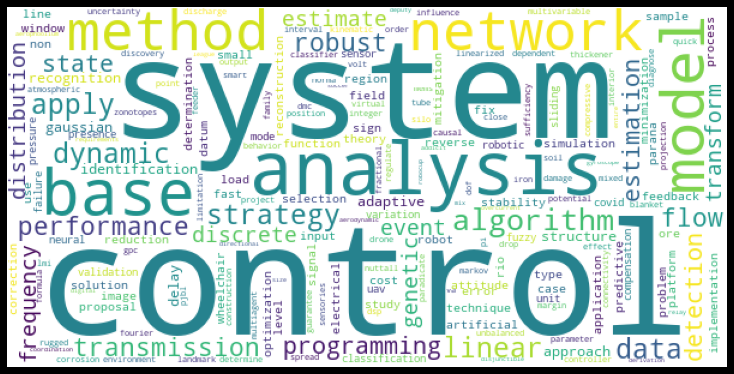

In [ ]:
wordcloud = WordCloud(collocations = False,width=600, height=300, background_color = 'white').generate(text)
plt.figure( figsize=(10,5), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('wordcloud.png')
plt.show()


In [ ]:
from collections import Counter

In [ ]:
cnt = Counter(text.split(' '))

In [ ]:
cnt.most_common(30)

[('control', 19),
 ('system', 15),
 ('analysis', 12),
 ('base', 9),
 ('model', 8),
 ('method', 7),
 ('network', 7),
 ('algorithm', 6),
 ('linear', 5),
 ('strategy', 5),
 ('apply', 5),
 ('data', 5),
 ('dynamic', 5),
 ('performance', 4),
 ('transmission', 4),
 ('flow', 4),
 ('robust', 4),
 ('programming', 4),
 ('estimation', 4),
 ('state', 4),
 ('detection', 4),
 ('frequency', 3),
 ('discrete', 3),
 ('event', 3),
 ('distribution', 3),
 ('estimate', 3),
 ('genetic', 3),
 ('transform', 3),
 ('recognition', 3),
 ('adaptive', 3)]

## avaliando SDG-1

In [ ]:
inference[inference['SDG 1'] == 1]

,Title,SDG 1,SDG 2,SDG 3,SDG 4,SDG 5,SDG 6,SDG 7,SDG 8,SDG 9,SDG 10,SDG 11,SDG 12,SDG 13,SDG 14,SDG 15,SDG 16
22,Algorithm Super-Twisting Adaptive Multivariabl...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,Application development for defining the best ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31,A sociodemographic data-oriented methodology f...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
219,Single-Stage LED Driver With Dimming and Unive...,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
223,Hybrid system of support for investment decisi...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
233,Command Governor Strategy Based on Region of A...,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
261,Analysis of financial impacts on the evolution...,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
303,Control Project FeedForward using linear matri...,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
323,Epidemic control based only on social detachment,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
325,Metaheuristic Search for Optimum Cost-Benefit ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
for sdg in inference.columns[1:]:
  labels = pd.Series(X).iloc[inference[inference[sdg] == 1].index].values
  all_labels = ' '.join(labels)
  words_list = all_labels.split(' ')
  cnt = Counter(words_list)
  print(sdg)
  print(cnt.most_common(10))
  print('-----------------')

SDG 1
[('system', 4), ('control', 4), ('base', 3), ('application', 2), ('stage', 2), ('decision', 2), ('analysis', 2), ('distribution', 2), ('inequality', 2), ('cost', 2)]
-----------------
SDG 2
[('linear', 5), ('system', 5), ('network', 4), ('frequency', 4), ('parameter', 4), ('subject', 3), ('development', 3), ('base', 3), ('discrete', 3), ('time', 3)]
-----------------
SDG 3
[('model', 14), ('system', 12), ('vehicle', 11), ('control', 10), ('analysis', 7), ('covid', 6), ('base', 5), ('distribution', 5), ('autonomous', 5), ('electric', 4)]
-----------------
SDG 4
[('learn', 15), ('system', 15), ('control', 10), ('base', 8), ('feedback', 8), ('learning', 7), ('robot', 7), ('project', 7), ('machine', 7), ('apply', 7)]
-----------------
SDG 5
[('optimal', 1), ('control', 1), ('concern', 1), ('covid', 1), ('sars', 1), ('cov', 1), ('pandemic', 1), ('bahia', 1), ('santa', 1), ('catarina', 1)]
-----------------
SDG 6
[('control', 8), ('fuzzy', 4), ('system', 4), ('line', 4), ('apply', 3), 

# Grafos

In [ ]:
import networkx as nx


In [ ]:
inference

,Title,SDG 1,SDG 2,SDG 3,SDG 4,SDG 5,SDG 6,SDG 7,SDG 8,SDG 9,SDG 10,SDG 11,SDG 12,SDG 13,SDG 14,SDG 15,SDG 16
0,A New Discrete-Time Robust Adaptive Predictive...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
1,Applied stochastic programming to optimal phot...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Design of an instrumented bench for rotary cut...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3,Detection of expulsion into spot welding proce...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,Estimation of states of a thermoelectrically c...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,LQR-Gain Scheduling Controllers for LPV System...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
773,Extensioner Methodology for Teaching Robots Fo...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
774,Iris Image Quality On Enhanced Biometric Recog...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
775,Optimum Allocation of Simplified Automatic Rec...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [ ]:
graph_df = inference.copy()

In [ ]:
graph_df.columns = ['Title', 'ODS 1', 'ODS 2', 'ODS 3', 'ODS 4', 'ODS 5', 'ODS 6', 'ODS 7',
       'ODS 8', 'ODS 9', 'ODS 10', 'ODS 11', 'ODS 12', 'ODS 13', 'ODS 14',
       'ODS 15', 'ODS 16']

In [ ]:
graph_df

,Title,ODS 1,ODS 2,ODS 3,ODS 4,ODS 5,ODS 6,ODS 7,ODS 8,ODS 9,ODS 10,ODS 11,ODS 12,ODS 13,ODS 14,ODS 15,ODS 16
0,A New Discrete-Time Robust Adaptive Predictive...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
1,Applied stochastic programming to optimal phot...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Design of an instrumented bench for rotary cut...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
3,Detection of expulsion into spot welding proce...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,Estimation of states of a thermoelectrically c...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,LQR-Gain Scheduling Controllers for LPV System...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
773,Extensioner Methodology for Teaching Robots Fo...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
774,Iris Image Quality On Enhanced Biometric Recog...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
775,Optimum Allocation of Simplified Automatic Rec...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [ ]:
new_df = pd.DataFrame()
new_list = []
for col_1 in graph_df.columns[1:]:
  for col_2 in graph_df.columns[1:]:
    if col_1 != col_2:

      len_it  = len(graph_df[(graph_df[col_1] == 1) & (graph_df[col_2] == 1)])
      if len_it > 0:
        new_list.append((col_1,col_2,len_it))

In [ ]:
pd.DataFrame(new_list)

,0,1,2
0,ODS 1,ODS 3,4
1,ODS 1,ODS 8,6
2,ODS 1,ODS 10,6
3,ODS 1,ODS 11,1
4,ODS 2,ODS 3,2
...,...,...,...
77,ODS 15,ODS 13,1
78,ODS 15,ODS 14,1
79,ODS 16,ODS 3,2
80,ODS 16,ODS 5,2


In [ ]:
from itertools import combinations
new_list = []
c = list(combinations(graph_df.columns[1:], 2))
for i,j in c:
  len_it  = len(graph_df[(graph_df[i] == 1) & (graph_df[j] == 1)])
  if len_it > 0:
    new_list.append((i,j,len_it))


In [ ]:
graph_df = pd.DataFrame(new_list,columns=['ODS 1','ODS 2','COUNT'])

In [ ]:
graph_df['relations'] = list(zip(graph_df['ODS 1'], graph_df['ODS 2']))
graph_df = graph_df[['relations','COUNT']].copy()
graph_df

,relations,COUNT
0,"(ODS 1, ODS 3)",4
1,"(ODS 1, ODS 8)",6
2,"(ODS 1, ODS 10)",6
3,"(ODS 1, ODS 11)",1
4,"(ODS 2, ODS 3)",2
5,"(ODS 2, ODS 7)",2
6,"(ODS 2, ODS 9)",5
7,"(ODS 3, ODS 4)",3
8,"(ODS 3, ODS 5)",2
9,"(ODS 3, ODS 7)",10


In [ ]:
d = graph_df.set_index('relations').T.to_dict('records')

G = nx.Graph()

In [ ]:
for k, v in d[0].items():
 G.add_edge(k[0], k[1], weight=np.log1p(v))

In [ ]:
?nx.draw()

In [ ]:
degree_dict=nx.degree_centrality(G)

In [ ]:
degree_dict

{'ODS 1': 0.26666666666666666,
 'ODS 10': 0.2,
 'ODS 11': 0.5333333333333333,
 'ODS 12': 0.13333333333333333,
 'ODS 13': 0.4,
 'ODS 14': 0.3333333333333333,
 'ODS 15': 0.2,
 'ODS 16': 0.2,
 'ODS 2': 0.2,
 'ODS 3': 0.6,
 'ODS 4': 0.26666666666666666,
 'ODS 5': 0.13333333333333333,
 'ODS 6': 0.13333333333333333,
 'ODS 7': 0.6666666666666666,
 'ODS 8': 0.4666666666666667,
 'ODS 9': 0.7333333333333333}

In [ ]:
list(nx.degree_centrality(G).values())

[0.26666666666666666,
 0.6,
 0.4666666666666667,
 0.2,
 0.5333333333333333,
 0.2,
 0.6666666666666666,
 0.7333333333333333,
 0.26666666666666666,
 0.13333333333333333,
 0.3333333333333333,
 0.2,
 0.13333333333333333,
 0.4,
 0.2,
 0.13333333333333333]

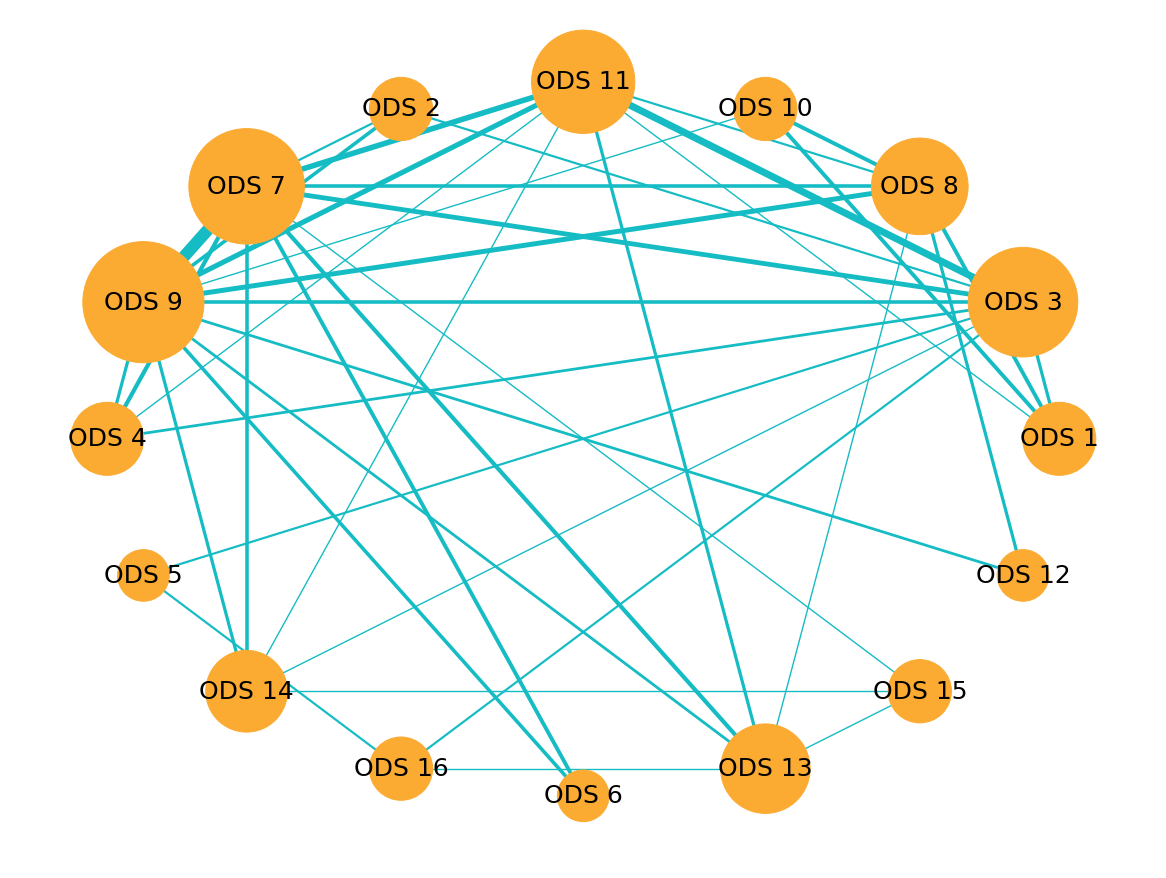

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))
weights = nx.get_edge_attributes(G,'weight').values()
weights = list(weights)
weights = [i*2 for i in weights]

pos = nx.circular_layout(G)
nx.draw(G, pos, 
        edge_color='#16BCC4', 
        width=list(weights),
        with_labels=True,
        node_color='#FBAB32',
        node_size=[i*20000 for i in nx.degree_centrality(G).values()],
        font_size=25,
        ax=ax
        )
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('graph_v2.png')
plt.show()


In [ ]:
inference[inference['SDG 15'] == 1]

,Title,SDG 1,SDG 2,SDG 3,SDG 4,SDG 5,SDG 6,SDG 7,SDG 8,SDG 9,SDG 10,SDG 11,SDG 12,SDG 13,SDG 14,SDG 15,SDG 16
213,Classification of faults in transmission lines...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
387,Optimized microorree recomposition with interm...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
411,Grouping and rating of rural energy consumers ...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
449,Nonlinear Gray-Box Identification Of A Landing...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
480,Clear Index Estimation Using Aqui Method and G...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
657,Use of RGB-D Camera for Analysis of Compensato...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


AttributeError: ignored

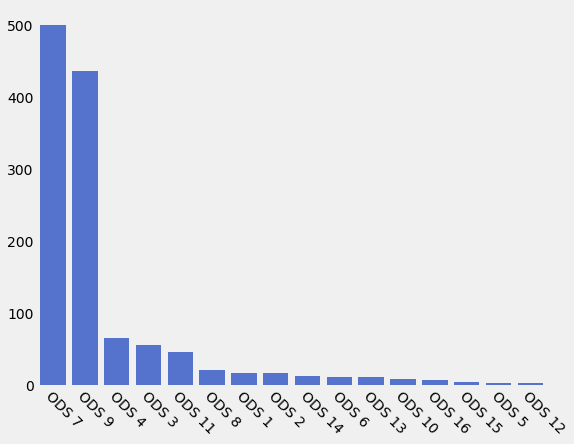

In [ ]:
# plotting histogram
import seaborn as sns
plt.style.use('fivethirtyeight')

data2plot = inference.iloc[:, 1:].sum(axis=0)
data2plot.sort_values(inplace=True, ascending=False)

# changing from SDG to ODS
index2change = data2plot.index
index2change = [sdg.replace('SDG', 'ODS') for sdg in index2change]
data2plot.index = index2change

fig, ax = plt.subplots(figsize=(8, 6))
plt.tight_layout()
plt.grid()

sns.barplot(data2plot.index, data2plot.values, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(),rotation=-45, rotation_mode="anchor", ha="left")
ax.bar_label(ax.containers[0])
ax.set(ylabel='Frequência')
# data2plot.plot(kind='bar')
# plt.savefig("sgd_histogram.png", dpi=400, facecolor="white")

In [ ]:
data2plot.to_csv('plota_isso.csv')